# Day 3: Fama-French 5-Factor Model

## Learning Objectives
- Understand the 5-Factor Model extension
- Construct RMW (Profitability) and CMA (Investment) factors
- Compare FF3 vs FF5 explanatory power
- Interpret factor loadings for investment decisions

## Key Formula
$$R_i - R_f = \alpha + \beta^M MKT + \beta^{SMB} SMB + \beta^{HML} HML + \beta^{RMW} RMW + \beta^{CMA} CMA + \epsilon$$

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

# Configuration
DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Load data
df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

print("="*60)
print("FAMA-FRENCH 5-FACTOR MODEL - DAY 3")
print("="*60)
print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

FAMA-FRENCH 5-FACTOR MODEL - DAY 3
Data: 1834 days, 63 assets


## 1. Construct All 5 Factors

In [2]:
# Market factor
market_returns = returns['SPY']
daily_rf = RISK_FREE_RATE / TRADING_DAYS
MKT = market_returns - daily_rf

# SMB Factor (Small Minus Big) - using volatility as proxy for size
volatilities = returns.std()
median_vol = volatilities.median()
small_stocks = volatilities[volatilities > median_vol].index.tolist()
big_stocks = volatilities[volatilities <= median_vol].index.tolist()

for lst in [small_stocks, big_stocks]:
    if 'SPY' in lst:
        lst.remove('SPY')

SMB = returns[small_stocks].mean(axis=1) - returns[big_stocks].mean(axis=1)

# HML Factor (High Minus Low B/M) - using momentum as proxy
past_returns = returns.rolling(126).mean().iloc[-1]
median_ret = past_returns.median()
value_stocks = past_returns[past_returns < median_ret].index.tolist()
growth_stocks = past_returns[past_returns >= median_ret].index.tolist()

for lst in [value_stocks, growth_stocks]:
    if 'SPY' in lst:
        lst.remove('SPY')

HML = returns[value_stocks].mean(axis=1) - returns[growth_stocks].mean(axis=1)

print("✅ MKT, SMB, HML factors constructed")

✅ MKT, SMB, HML factors constructed


In [3]:
# RMW Factor (Robust Minus Weak Profitability)
# Using Sharpe ratio as proxy for profitability
sharpe_ratios = returns.mean() / returns.std()
median_sharpe = sharpe_ratios.median()

robust_stocks = sharpe_ratios[sharpe_ratios >= median_sharpe].index.tolist()
weak_stocks = sharpe_ratios[sharpe_ratios < median_sharpe].index.tolist()

for lst in [robust_stocks, weak_stocks]:
    if 'SPY' in lst:
        lst.remove('SPY')

RMW = returns[robust_stocks].mean(axis=1) - returns[weak_stocks].mean(axis=1)

print(f"RMW Factor (Profitability):")
print(f"   Robust stocks: {len(robust_stocks)}")
print(f"   Weak stocks: {len(weak_stocks)}")
print(f"   Mean (annual): {RMW.mean() * TRADING_DAYS:.2%}")

RMW Factor (Profitability):
   Robust stocks: 31
   Weak stocks: 31
   Mean (annual): 13.55%


In [4]:
# CMA Factor (Conservative Minus Aggressive Investment)
# Using return stability as proxy for investment conservatism
return_volatility = returns.rolling(60).std().mean()
median_stability = return_volatility.median()

conservative_stocks = return_volatility[return_volatility <= median_stability].index.tolist()
aggressive_stocks = return_volatility[return_volatility > median_stability].index.tolist()

for lst in [conservative_stocks, aggressive_stocks]:
    if 'SPY' in lst:
        lst.remove('SPY')

CMA = returns[conservative_stocks].mean(axis=1) - returns[aggressive_stocks].mean(axis=1)

print(f"\nCMA Factor (Investment):")
print(f"   Conservative stocks: {len(conservative_stocks)}")
print(f"   Aggressive stocks: {len(aggressive_stocks)}")
print(f"   Mean (annual): {CMA.mean() * TRADING_DAYS:.2%}")


CMA Factor (Investment):
   Conservative stocks: 31
   Aggressive stocks: 31
   Mean (annual): -12.40%


In [5]:
# Combine all factors
factors5 = pd.DataFrame({
    'MKT': MKT,
    'SMB': SMB,
    'HML': HML,
    'RMW': RMW,
    'CMA': CMA
}).dropna()

factors3 = factors5[['MKT', 'SMB', 'HML']]

print("\n" + "="*60)
print("5-FACTOR CORRELATION MATRIX")
print("="*60)
print(factors5.corr().round(3))

print("\n💡 Look for factors with low correlations (independent risk sources)")


5-FACTOR CORRELATION MATRIX
       MKT    SMB    HML    RMW    CMA
MKT  1.000  0.422 -0.265  0.323 -0.428
SMB  0.422  1.000  0.420 -0.432 -0.996
HML -0.265  0.420  1.000 -0.838 -0.437
RMW  0.323 -0.432 -0.838  1.000  0.441
CMA -0.428 -0.996 -0.437  0.441  1.000

💡 Look for factors with low correlations (independent risk sources)


## 2. Run 5-Factor Regression

In [6]:
def run_ff_regression(stock_returns, factors, daily_rf):
    """Run Fama-French regression with any number of factors."""
    excess_returns = stock_returns - daily_rf
    
    aligned = pd.concat([excess_returns, factors], axis=1).dropna()
    y = aligned.iloc[:, 0]
    X = sm.add_constant(aligned[factors.columns])
    
    return sm.OLS(y, X).fit()

test_stocks = ['AAPL', 'MSFT', 'JPM', 'XOM', 'JNJ', 'AMZN']

print("\n" + "="*80)
print("FAMA-FRENCH 5-FACTOR REGRESSION RESULTS")
print("="*80)
print(f"{'Stock':<8} {'α':<10} {'β_MKT':<8} {'β_SMB':<8} {'β_HML':<8} {'β_RMW':<8} {'β_CMA':<8} {'R²':<8}")
print("-"*80)

ff5_results = []
for stock in test_stocks:
    if stock in returns.columns:
        model = run_ff_regression(returns[stock], factors5, daily_rf)
        
        result = {
            'stock': stock,
            'alpha': model.params['const'] * TRADING_DAYS,
            'beta_mkt': model.params['MKT'],
            'beta_smb': model.params['SMB'],
            'beta_hml': model.params['HML'],
            'beta_rmw': model.params['RMW'],
            'beta_cma': model.params['CMA'],
            'r2': model.rsquared
        }
        ff5_results.append(result)
        
        print(f"{stock:<8} {result['alpha']:<10.2%} {result['beta_mkt']:<8.3f} "
              f"{result['beta_smb']:<8.3f} {result['beta_hml']:<8.3f} "
              f"{result['beta_rmw']:<8.3f} {result['beta_cma']:<8.3f} {result['r2']:<8.4f}")

ff5_df = pd.DataFrame(ff5_results)


FAMA-FRENCH 5-FACTOR REGRESSION RESULTS
Stock    α          β_MKT    β_SMB    β_HML    β_RMW    β_CMA    R²      
--------------------------------------------------------------------------------
AAPL     7.68%      1.099    -1.739   0.255    0.406    -1.877   0.6331  
MSFT     3.08%      1.112    -0.510   0.756    0.754    -0.471   0.7349  
JPM      7.07%      1.175    7.431    -0.341   -0.511   7.551    0.7792  
XOM      5.57%      0.672    1.274    -1.744   -1.449   0.886    0.6400  
JNJ      11.91%     0.893    0.095    -0.061   -0.671   0.695    0.4212  
AMZN     -9.79%     0.731    -1.825   0.974    1.409    -2.296   0.6216  


## 3. Compare Models: CAPM vs FF3 vs FF5

In [7]:
print("\n" + "="*70)
print("MODEL COMPARISON: CAPM vs FF3 vs FF5")
print("="*70)
print(f"{'Stock':<8} {'CAPM R²':<12} {'FF3 R²':<12} {'FF5 R²':<12} {'FF5-CAPM':<12}")
print("-"*70)

comparisons = []
for stock in test_stocks:
    if stock in returns.columns:
        # CAPM
        capm_factors = factors5[['MKT']]
        capm = run_ff_regression(returns[stock], capm_factors, daily_rf)
        
        # FF3
        ff3 = run_ff_regression(returns[stock], factors3, daily_rf)
        
        # FF5
        ff5 = run_ff_regression(returns[stock], factors5, daily_rf)
        
        improvement = ff5.rsquared - capm.rsquared
        
        comparisons.append({
            'stock': stock,
            'capm': capm.rsquared,
            'ff3': ff3.rsquared,
            'ff5': ff5.rsquared,
            'improvement': improvement
        })
        
        print(f"{stock:<8} {capm.rsquared:<12.4f} {ff3.rsquared:<12.4f} "
              f"{ff5.rsquared:<12.4f} {improvement:<12.4f}")

comp_df = pd.DataFrame(comparisons)

print("\n📊 Average R² Improvement:")
print(f"   CAPM → FF3: {(comp_df['ff3'] - comp_df['capm']).mean():.4f}")
print(f"   FF3 → FF5:  {(comp_df['ff5'] - comp_df['ff3']).mean():.4f}")


MODEL COMPARISON: CAPM vs FF3 vs FF5
Stock    CAPM R²      FF3 R²       FF5 R²       FF5-CAPM    
----------------------------------------------------------------------
AAPL     0.6038       0.6050       0.6331       0.0293      
MSFT     0.6443       0.6647       0.7349       0.0906      
JPM      0.5014       0.5495       0.7792       0.2778      
XOM      0.2599       0.4259       0.6400       0.3801      
JNJ      0.1921       0.2982       0.4212       0.2290      
AMZN     0.4405       0.4415       0.6216       0.1811      

📊 Average R² Improvement:
   CAPM → FF3: 0.0571
   FF3 → FF5:  0.1409


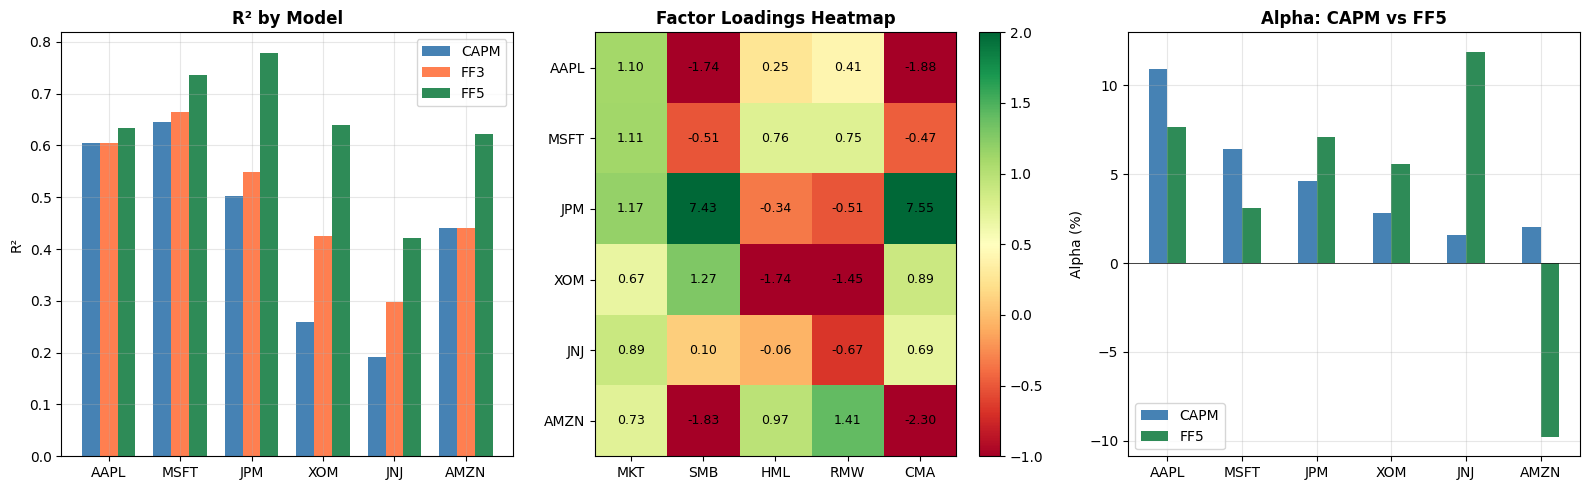

In [8]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# R² comparison
ax1 = axes[0]
x = np.arange(len(comp_df))
width = 0.25
ax1.bar(x - width, comp_df['capm'], width, label='CAPM', color='steelblue')
ax1.bar(x, comp_df['ff3'], width, label='FF3', color='coral')
ax1.bar(x + width, comp_df['ff5'], width, label='FF5', color='seagreen')
ax1.set_xticks(x)
ax1.set_xticklabels(comp_df['stock'])
ax1.set_ylabel('R²')
ax1.set_title('R² by Model', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Factor loadings heatmap
ax2 = axes[1]
loadings = ff5_df.set_index('stock')[['beta_mkt', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma']]
im = ax2.imshow(loadings.values, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=2)
ax2.set_xticks(range(len(loadings.columns)))
ax2.set_xticklabels(['MKT', 'SMB', 'HML', 'RMW', 'CMA'])
ax2.set_yticks(range(len(loadings)))
ax2.set_yticklabels(loadings.index)
ax2.set_title('Factor Loadings Heatmap', fontweight='bold')
plt.colorbar(im, ax=ax2)

# Add text annotations
for i in range(len(loadings)):
    for j in range(len(loadings.columns)):
        ax2.text(j, i, f'{loadings.values[i, j]:.2f}', ha='center', va='center', fontsize=9)

# Alpha comparison
ax3 = axes[2]
alphas = []
for stock in test_stocks:
    if stock in returns.columns:
        capm_factors = factors5[['MKT']]
        capm = run_ff_regression(returns[stock], capm_factors, daily_rf)
        ff5 = run_ff_regression(returns[stock], factors5, daily_rf)
        alphas.append({
            'stock': stock,
            'capm': capm.params['const'] * TRADING_DAYS,
            'ff5': ff5.params['const'] * TRADING_DAYS
        })

alpha_df = pd.DataFrame(alphas)
ax3.bar(x - width/2, alpha_df['capm']*100, width, label='CAPM', color='steelblue')
ax3.bar(x + width/2, alpha_df['ff5']*100, width, label='FF5', color='seagreen')
ax3.set_xticks(x)
ax3.set_xticklabels(alpha_df['stock'])
ax3.axhline(0, color='black', linewidth=0.5)
ax3.set_ylabel('Alpha (%)')
ax3.set_title('Alpha: CAPM vs FF5', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Factor Statistics


FACTOR STATISTICS
     Mean (Ann.)  Vol (Ann.)  Sharpe  Skewness  Kurtosis
MKT       0.1232      0.1938  0.6356   -0.2944   14.4599
SMB       0.1268      0.2037  0.6224   -6.1982  147.2500
HML      -0.0765      0.1792 -0.4268  -18.5263  625.7983
RMW       0.1355      0.1946  0.6964   14.2959  440.8294
CMA      -0.1240      0.1989 -0.6235    7.0140  172.4890


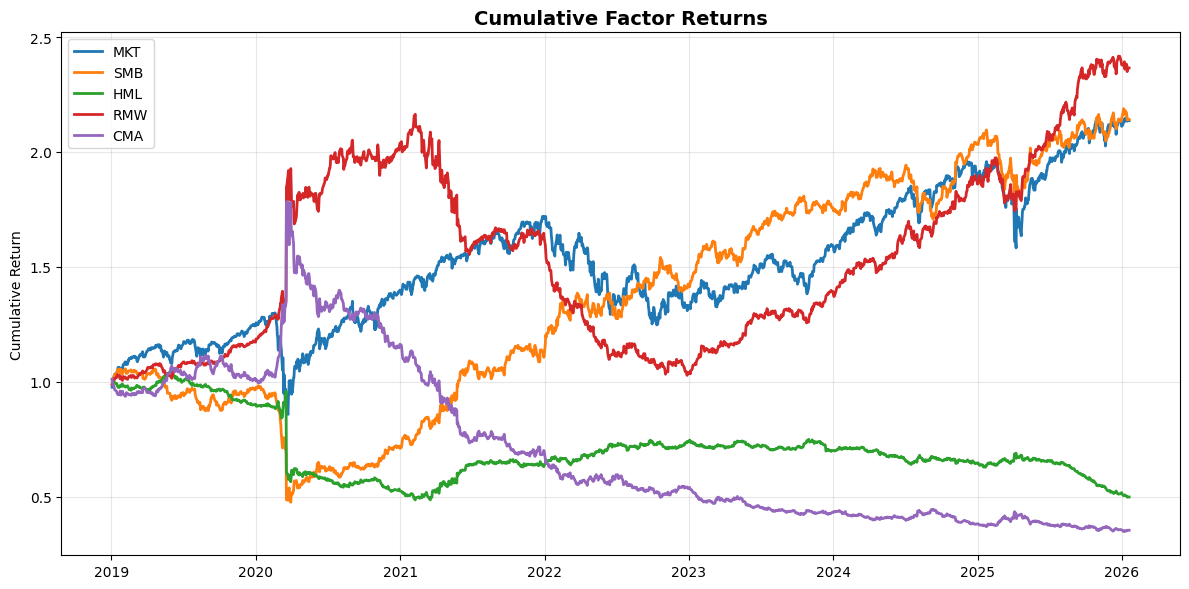

In [9]:
print("\n" + "="*70)
print("FACTOR STATISTICS")
print("="*70)

stats = pd.DataFrame({
    'Mean (Ann.)': factors5.mean() * TRADING_DAYS,
    'Vol (Ann.)': factors5.std() * np.sqrt(TRADING_DAYS),
    'Sharpe': (factors5.mean() / factors5.std()) * np.sqrt(TRADING_DAYS),
    'Skewness': factors5.skew(),
    'Kurtosis': factors5.kurtosis()
}).round(4)

print(stats)

# Cumulative factor performance
fig, ax = plt.subplots(figsize=(12, 6))

for col in factors5.columns:
    cum = (1 + factors5[col]).cumprod()
    ax.plot(cum, label=col, linewidth=2)

ax.set_title('Cumulative Factor Returns', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Diagnostics

In [10]:
# Detailed regression output for one stock
print("\n" + "="*60)
print("DETAILED FF5 REGRESSION: AAPL")
print("="*60)

if 'AAPL' in returns.columns:
    model = run_ff_regression(returns['AAPL'], factors5, daily_rf)
    print(model.summary())


DETAILED FF5 REGRESSION: AAPL
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     630.8
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        00:35:31   Log-Likelihood:                 5568.2
No. Observations:                1834   AIC:                        -1.112e+04
Df Residuals:                    1828   BIC:                        -1.109e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003

## Key Takeaways

1. **FF5 adds Profitability (RMW) and Investment (CMA)** to the 3-factor model
2. **More factors = Higher R²** but beware of overfitting
3. **RMW captures** profitable vs weak firms
4. **CMA captures** conservative vs aggressive investment
5. **Alpha typically decreases** as more factors explain returns

### Factor Interpretation
| Factor | Positive Beta | Negative Beta |
|--------|--------------|---------------|
| SMB | Small-cap tilt | Large-cap tilt |
| HML | Value tilt | Growth tilt |
| RMW | Quality tilt | Low-quality tilt |
| CMA | Conservative | Aggressive |

---
*Next: Day 4 - Arbitrage Pricing Theory (APT)*